In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks 

# Computational Essay
By Roy Lim z5310629

## Intro & Background

## Results

In [64]:
# Constants
hbar = 1.055e-34      # Js
q = 1.602e-19         # C
m = 9.1e-31           # kg
m_dot = 0.2 * m       # kg  
bohr_radii = 5.29e-11 # m
a = 1e-10  # m

In [28]:
def VQD(alpha, x1, x):
    return alpha * (x - x1) ** 2

def VDQD(alpha, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2)

def VF(alpha, F, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x

def VFT(alpha, F, omega, x1, x2, x, t):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x * np.cos(omega * t)

* np.ones(Np)### Part A
We can solve the Hamiltonian:
$$
    H = 
    \begin{bmatrix}
    E & t \\
    t* & -E \\ 
    \end{bmatrix}
$$
to get the following eigenvalues: $\lambda_1 = -\sqrt{t^2 + E^2} $, $\lambda_2 = \sqrt{t^2 + E^2}$ and given eigenvectors:
$$
    | \lambda_2 \rangle = 
    \begin{bmatrix}
        E - \sqrt{t^2 + E^2} \\ 
        t
    \end{bmatrix}
    | \lambda_2 \rangle = 
    \begin{bmatrix}
       E + \sqrt{t^2 + E^2} \\ 
       t 
    \end{bmatrix}
$$
Therefore $E_2 - E_1 = 2\sqrt{t^2 + E^2}$, min value for $E_2 - E_1$ is $2t$

For an energy state $| \lambda \rangle = \begin{bmatrix} a \\ b\end{bmatrix}$, the probability of being in state $|0\rangle$ and $|1\rangle$ is $|a|^2$ and $|b|^2$ respectively.
Note that $|a|^2 + |b|^2 = 1$ and that $t$ is real (meaning $t* = t$)

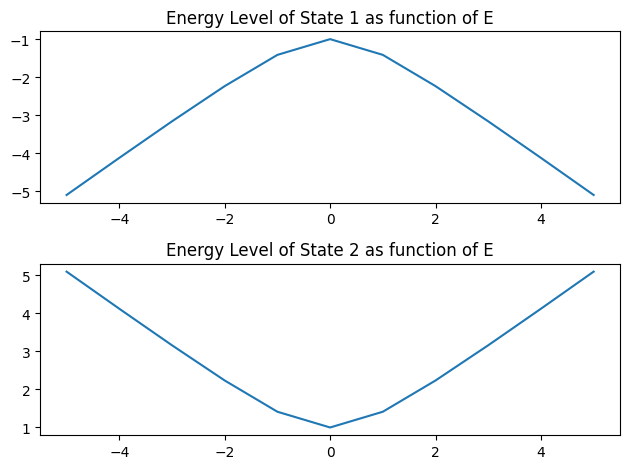

In [5]:
t = 1
E = [e for e in range(-5, 6)]
fig, axes = plt.subplots(2)
state1 = axes[0]
state2 = axes[1]
state1.plot([e for e in E], [-np.sqrt(t ** 2 + e ** 2)for e in E])
state1.set_title('Energy Level of State 1 as function of E')
state2.plot([e for e in E], [np.sqrt(t ** 2 + e ** 2)for e in E])
state2.set_title('Energy Level of State 2 as function of E')
plt.tight_layout()

In [6]:
# a = E, b = t
probability_matrix = [
    [
        lambda a, b: (a + np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ],
    [
        lambda a, b: (a - np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ]
]

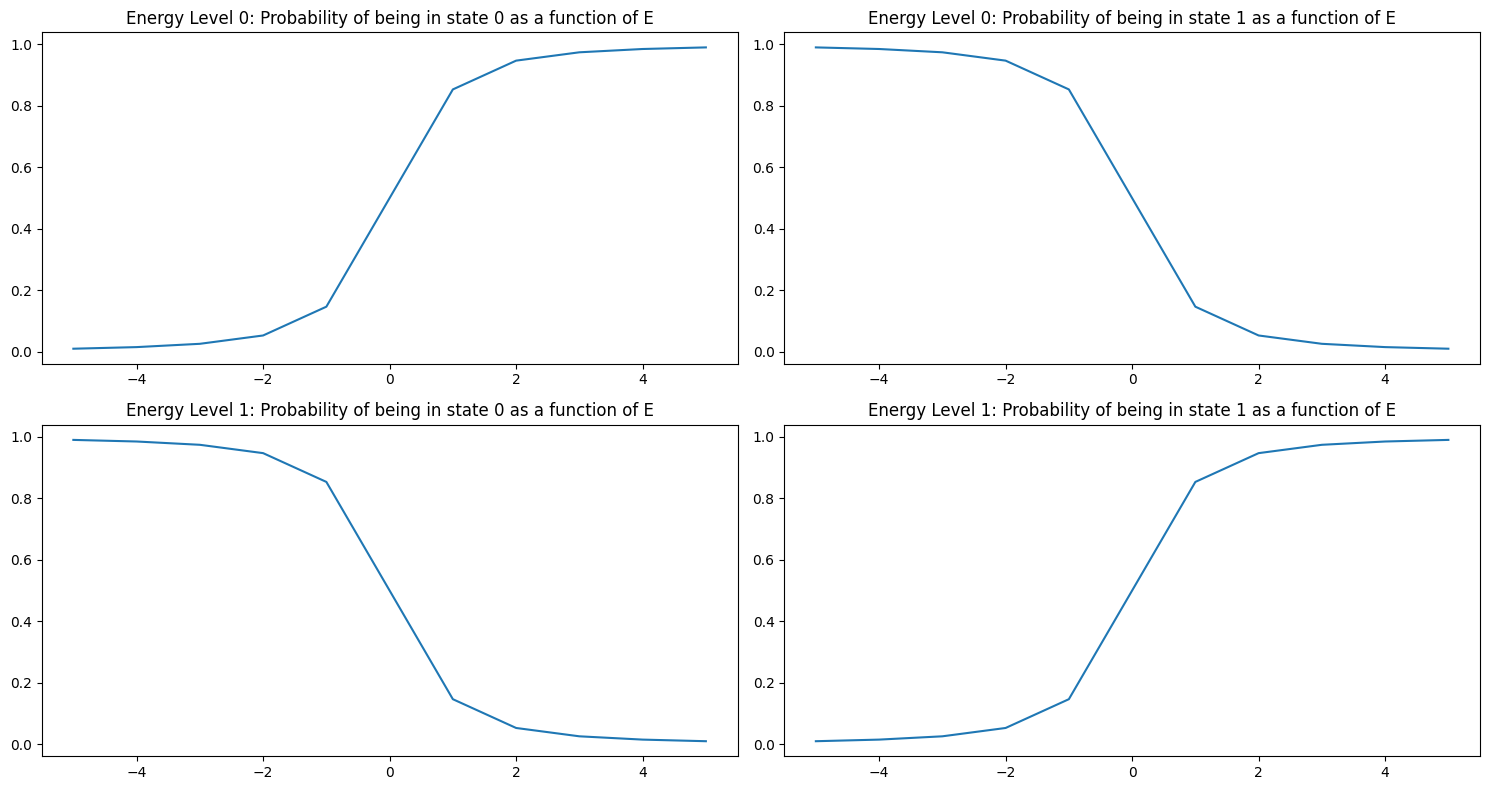

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
for energy_level in [0, 1]:
    for state in [0, 1]:
        ax = axes[energy_level, state]
        ax.plot([e for e in E], [probability_matrix[energy_level][state](e, t) for e in E], '-')
        ax.set_title(f'Energy Level {energy_level}: Probability of being in state {state} as a function of E')
        
plt.tight_layout()

### Part B

In [8]:
# Constants
Np = 500
X = a * np.linspace(1, Np / 2, Np) / 1e-9 # nm
# divide by q to convert to eV, accounting for mass of quantum dot ~ 0.2 mass of electron
t0 = (hbar * hbar) / (2 * 0.2 * m * a * a) / q
on = 2.0 * t0 * np.ones(Np)
off = -t0 * np.ones(Np - 1)
alpha = 8e-5
x1 = 12.5 # nm

In [9]:
def compute_eigenvalue_eigenstates(U):
    H = np.diag(on + U) + np.diag(off, 1) + np.diag(off, -1)
    W, V = np.linalg.eig(H)
    idx = W.argsort()[::1]
    W = W[idx]
    V = V[:, idx]
    return W, V

#### Sweeping Potential Energy 

In [10]:
for pow in range(-10, 0):
    alpha_test = 10 ** pow
    U = np.array([VQD(alpha_test, x1,  x) for x in X])
    W, _ = compute_eigenvalue_eigenstates(U)
    print(f'Alpha {alpha_test:.2E} yields Energy Gap of {(W[1] - W[0]) / 1e-3 :.2f} meV')

Alpha 1.00E-10 yields Energy Gap of 2.25 meV
Alpha 1.00E-09 yields Energy Gap of 2.25 meV
Alpha 1.00E-08 yields Energy Gap of 2.25 meV
Alpha 1.00E-07 yields Energy Gap of 2.25 meV
Alpha 1.00E-06 yields Energy Gap of 2.28 meV
Alpha 1.00E-05 yields Energy Gap of 2.49 meV
Alpha 1.00E-04 yields Energy Gap of 4.46 meV
Alpha 1.00E-03 yields Energy Gap of 13.79 meV
Alpha 1.00E-02 yields Energy Gap of 43.60 meV
Alpha 1.00E-01 yields Energy Gap of 137.82 meV


#### Computation for Energy Gap of 4meV

In [11]:
U = np.array([VQD(alpha, x1,  x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

In [12]:
print(f'Energy Gap: {(W[1] - W[0]) / 1e-3} meV')

Energy Gap: 4.061049022396614 meV


In [13]:
Psi0 = np.multiply(V[:, 0], V[:, 0])
Psi1 = np.multiply(V[:, 1], V[:, 1])

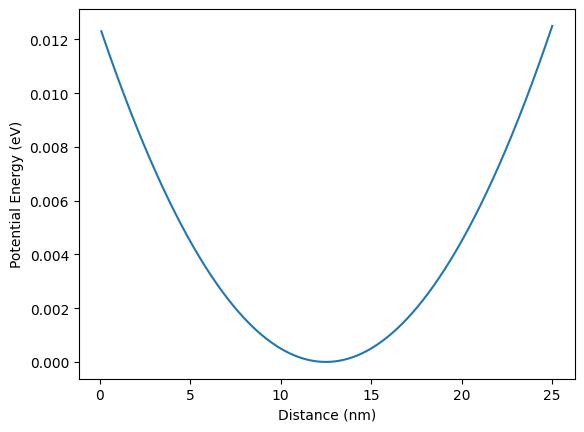

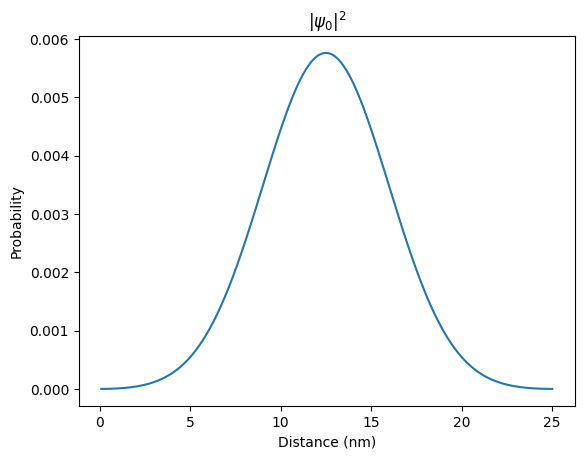

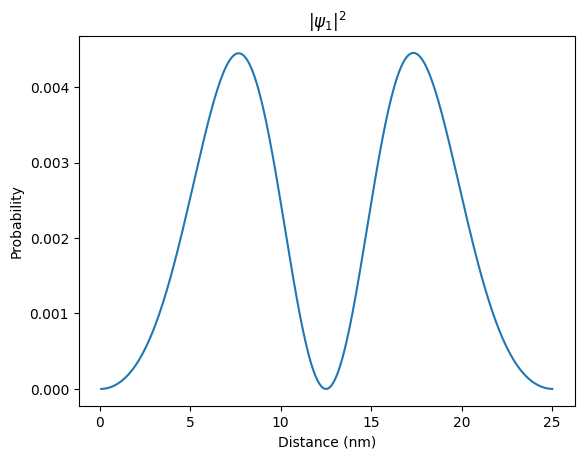

In [14]:
plt.figure(1)
plt.plot(X, U)
plt.xlabel('Distance (nm)')
plt.ylabel('Potential Energy (eV)')
plt.show()

plt.figure(2)
plt.plot(X, Psi0)
plt.xlabel('Distance (nm)')
plt.ylabel('Probability')
plt.title(r'$|\psi_0|^2$')
plt.show()

plt.figure(3)
plt.plot(X, Psi1)
plt.xlabel('Distance (nm)')
plt.ylabel('Probability')
plt.title(r'$|\psi_1|^2$')
plt.show()

In [15]:
(peak1, peak2), _ = find_peaks(Psi1)
number_of_atoms_spanned = (X[peak2] - X[peak1]) / .543e-9
print(f'Number of Atoms Spanned: {number_of_atoms_spanned:.2E}')

Number of Atoms Spanned: 1.77E+10


i) 
Alpha is related to the potential energy of the gate. 
This means we can adjust it with parameters such as temperature and voltage applied.
In addition, adjusting the thickness of the layers of SiO2 and Si may also affect alpha.
Temperature range we expect for the device to work would be low (close to 0K), otherwise the thermal fluctuation may cause decoherence. 
ii)
Inaccurate meshing can be partially remediated by increasingly the granularity between points.
For instance, I decreased the space from 1 nm to 0.5 nm.
iii)
Quantum dots are called artificial atoms as they have discrete energy levels similar to how electrons do in an atom.
The length scale of the work function chosen is the distance between the two major peaks in the probability density function. 

### Part C

In [16]:
def plot_graph(x, y, xlabel, ylabel, title, axis=None):
    if axis is not None:
        axis.plot(x, y)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    else:
        plt.plot(x, y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

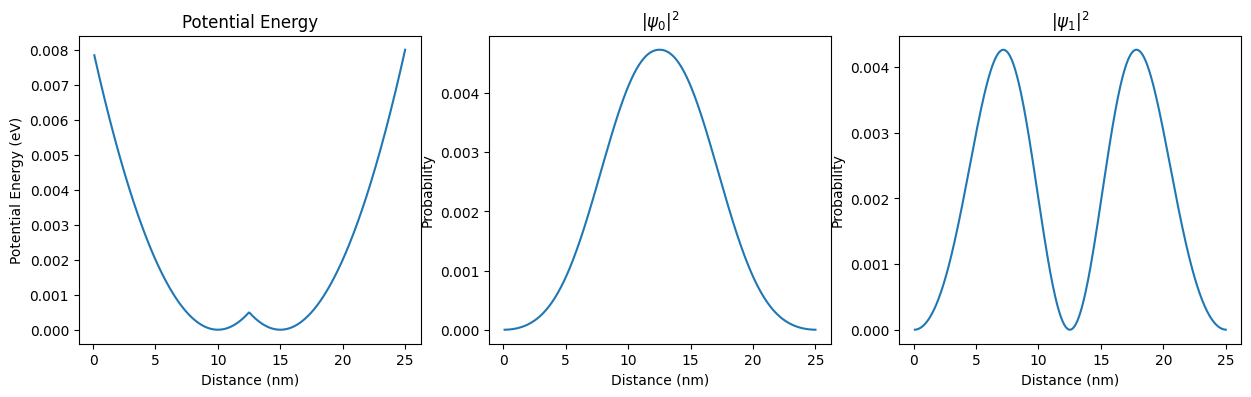

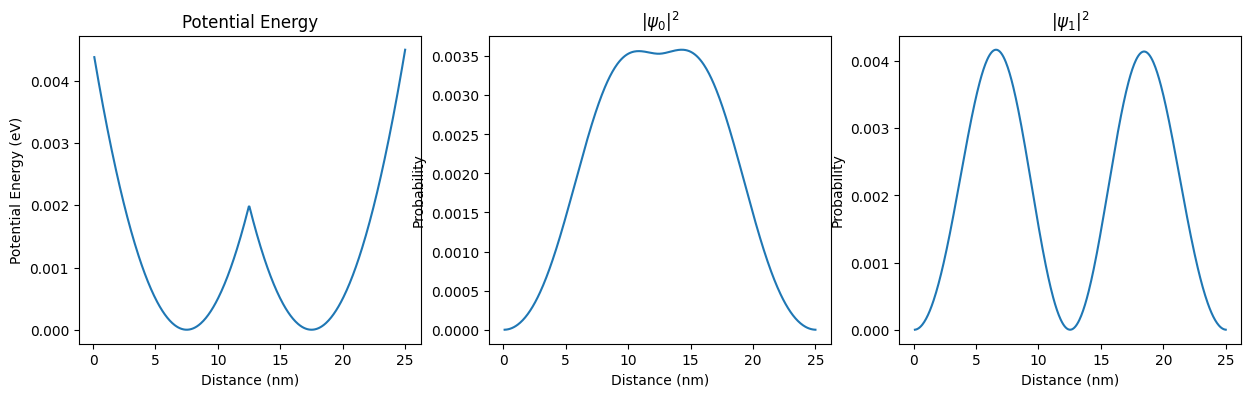

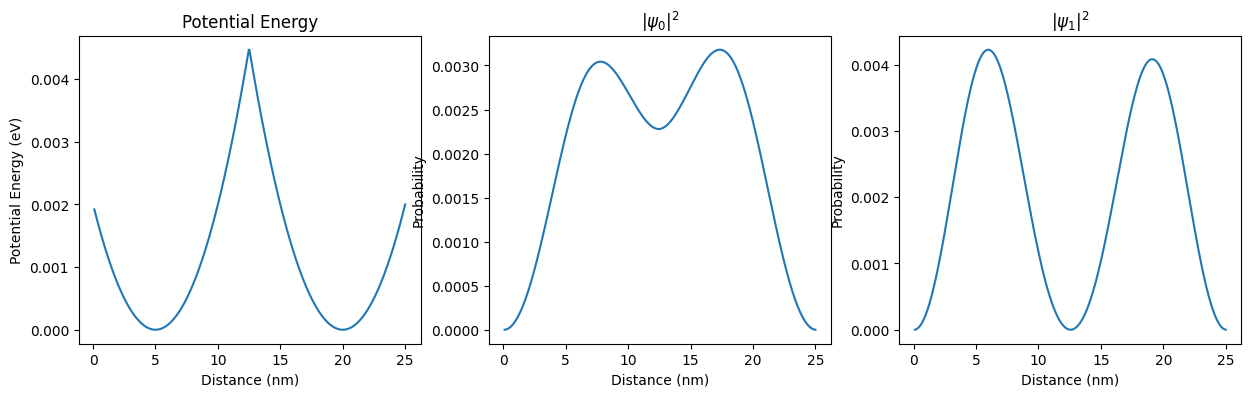

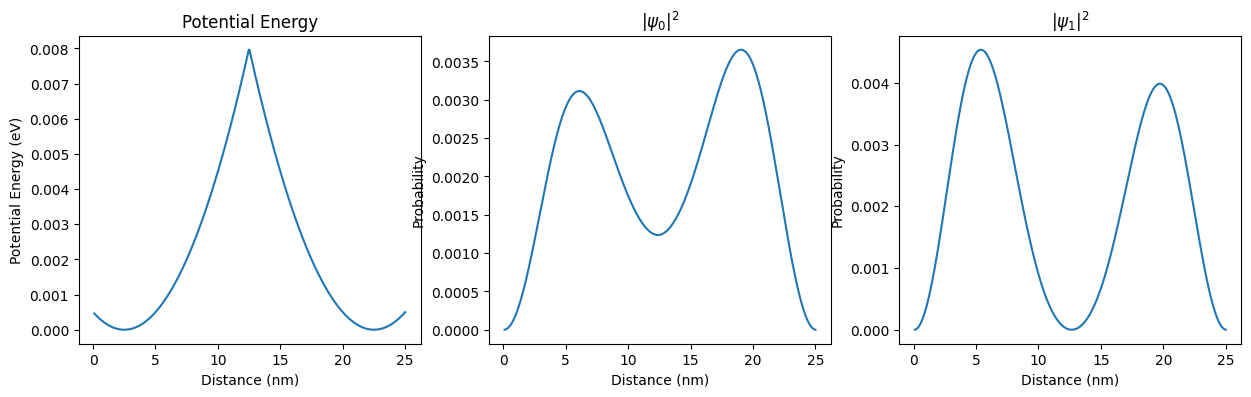

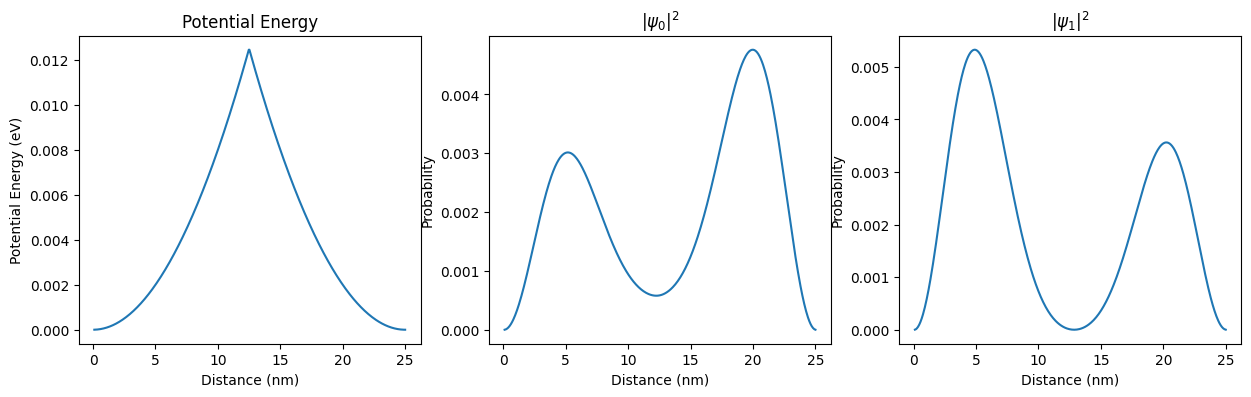

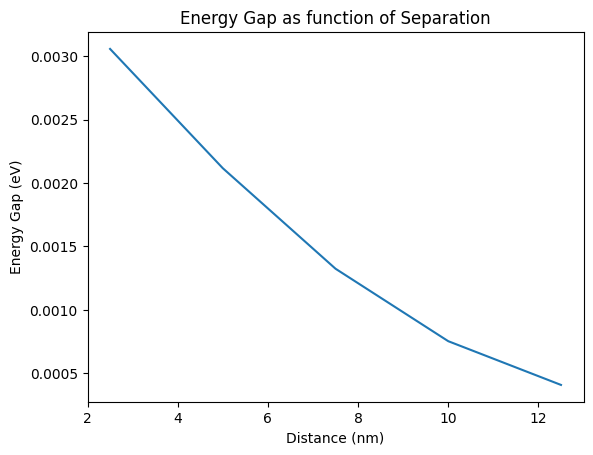

In [17]:
seperation = []
energy_difference = []

for index, R in enumerate([2.5, 5, 7.5, 10, 12.5]):
    x1 = 12.5 - R
    x2 = 12.5 + R
    # Create Potential Energy and Probability Curves for 2 lowest energy state
    U = np.array([VDQD(alpha, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', 'Potential Energy (eV)', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plt.show()

    # Create data for energy difference per centre-to-centre dot separation
    seperation.append(R)
    energy_difference.append(W[1] - W[0])
    
plot_graph(seperation, energy_difference, 'Distance (nm)', 'Energy Gap (eV)', 'Energy Gap as function of Separation')

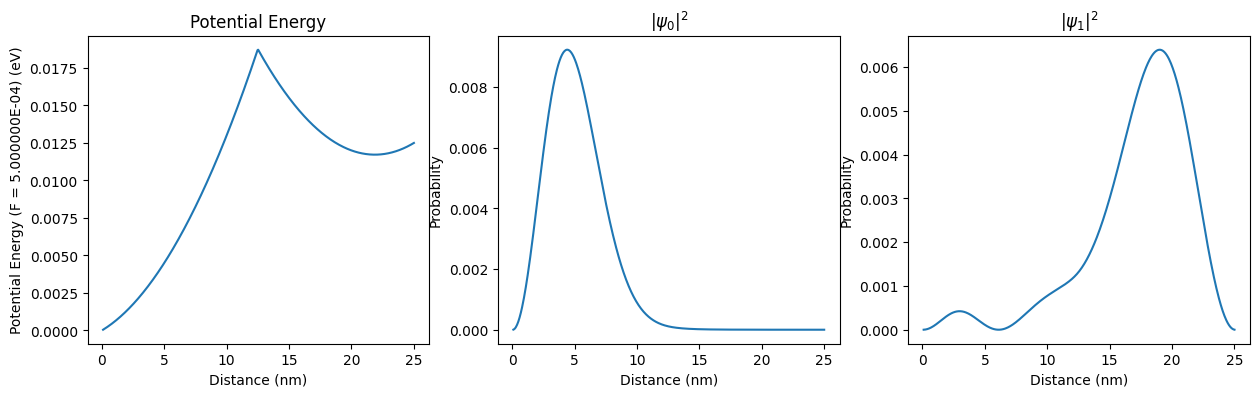

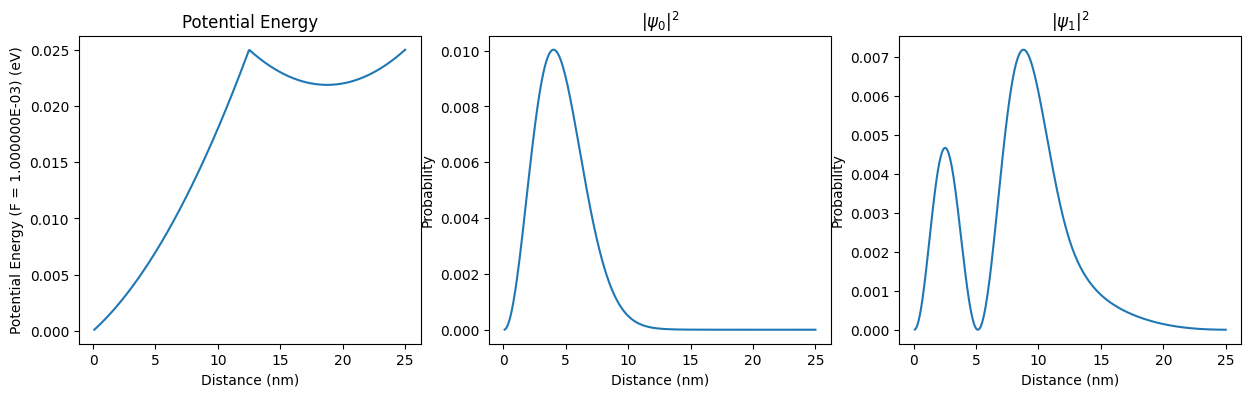

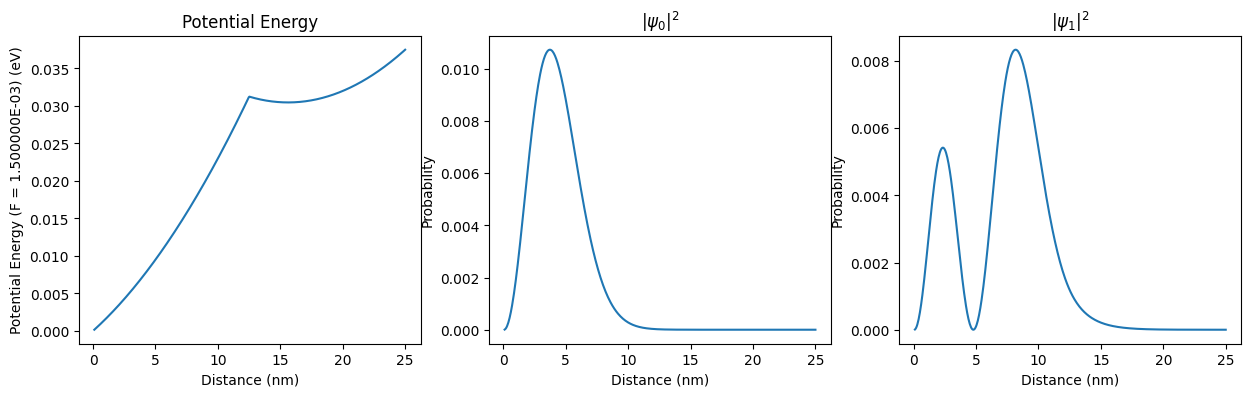

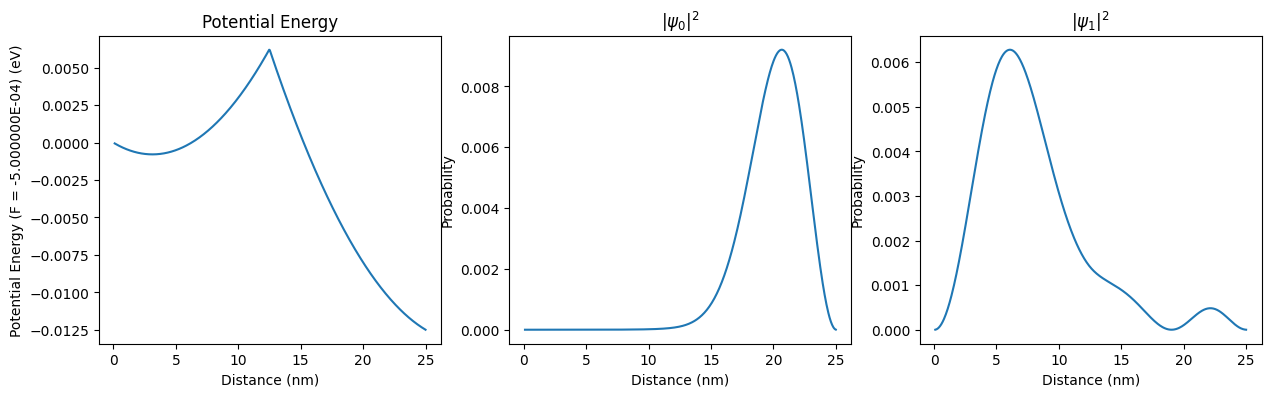

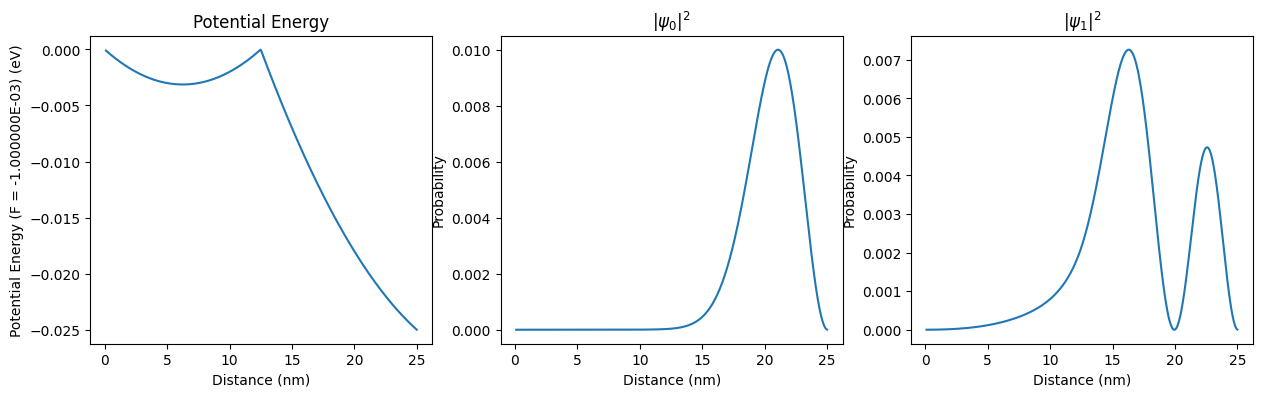

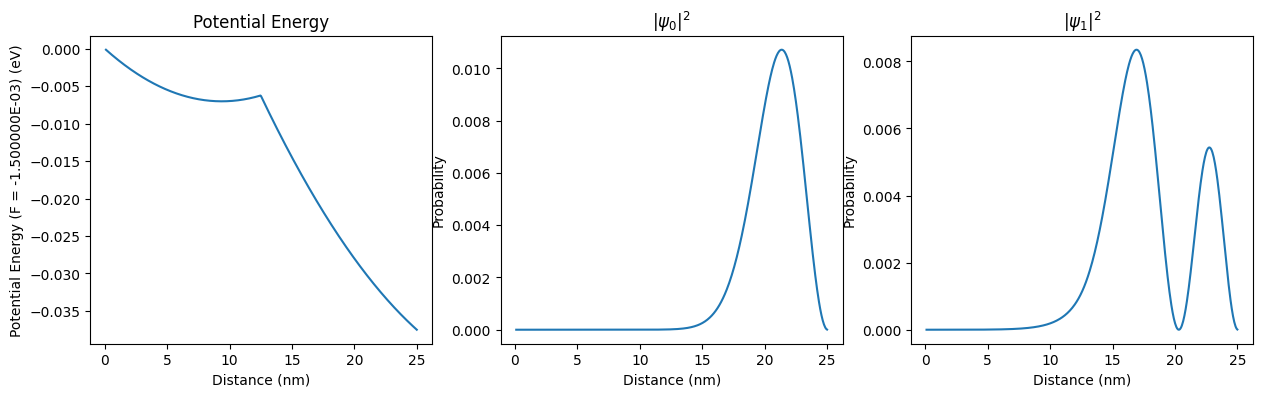

In [20]:
for F in np.array([5, 10, 15] + [-5, -10, -15]) * 1e-4:
    U = np.array([VF(alpha, F, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', f'Potential Energy (F = {F:2E}) (eV)', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plt.show()

i)
The probability for lowest energy state gradually goes from uni-modal to bimodal, with one peak preferred over the other.
The probability for the second-lowest energy state gradually grows from being symmetric with two peaks, to preferring one peak.
It appears the preference for peak is opposite for the first and second lowest energy states.
ii)
It looks like the energy gap decreases between first two eigenstates as the centre-to-centre dot separation increases over time.
Recall that $H \psi = E \psi$. 
When we change the potential energy by manipulating the centre-to-centre separation, we are changing the diagonal.
The only Pauli matrix that does so is $\sigma_z$.
iii)
???

### Part D

Recall for Finite Difference Method, for some arbitrary function $T$ and differential equations $\frac{\partial T}{\Delta t} = \alpha \frac{\partial^2 T}{\Delta x^2}$, that we choose time steps $\partial t$ and $\partial x$ such that $\frac{\alpha \Delta t}{\Delta x^2} = \gamma << 1$

In [159]:
# Finding Initial Condition
U = np.array([VF(alpha, F, x1, x2, x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

In [160]:
F = 1e-3
omega = (W[1] - W[0]) * q / hbar
print(f'Period of Oscillation is = {(2 * np.pi) / omega:.2E}')

Period of Oscillation is = 3.32E-13


In [161]:
# Constants
Np = 500
Nt = 500
T = np.linspace(0, 2 * np.pi / omega, Nt)         # S
dt = 2 * np.pi / omega / Nt                       # s
X = a * np.linspace(0, Np / 2, Np) / 1e-9         # nm
dx = (max(X) - min(X)) / Np                       # nm
x1 = 12.5 - 6.25                                  # nm
x2 = 12.5 + 6.25                                  # nm
alpha = 8e5                                       # eV / nm^2 
gamma = alpha * dt / dx ** 2                      # Check that method is valid for given value of dt and dx
print(f'Gamma = {gamma:.2E}')

Gamma = 2.12E-07


In [162]:
# Set initial chi to be ground state
chi0 = np.array(np.multiply(V[:, 0], V[:, 0]), dtype='complex')
chi = np.zeros((Nt, Np), dtype='complex_')

In [163]:
# Source Term - Spatial Boundary condition
st = np.zeros(Np, dtype='complex_')

In [164]:
vectorized_VFT = np.vectorize(VFT)

def construct_A(X, t):
    on = -1j * (hbar * dt / (2 * m_dot * dx ** 2) * np.ones(Np) + dt / hbar * np.array(vectorized_VFT(alpha, F, omega, x1, x2, X, t), dtype='complex_'))
    off = hbar * dt / (2 * m_dot * dx ** 2) * 1j * np.ones(Np - 1)
    A = np.diag(on) + np.diag(off, 1) + np.diag(off, -1)
    # Accounting for boundary conditions
    A[0, 0] = -1j * (hbar * dt / (2 * m_dot * dx ** 2)) / 2 + dt / hbar * VFT(alpha, F, omega, x1, x2, X[0], t) 
    A[Np - 1, Np - 1] = -1j * (hbar * dt / (2 * m_dot * dx ** 2)) / 2 + dt / hbar * VFT(alpha, F, omega, x1, x2, X[-1], t) 
    return A

In [165]:
chi_next = chi0
chi[0, :] = chi0

In [166]:
p0 = np.array([])
p1 = np.array([])

for i in range(1, 3):
    t = T[i]
    A = construct_A(X, t)
    chi_next = np.matmul(A, np.transpose(chi_next)) + chi_next * st 
    chi[i, :] = chi_next
    p0 = np.append(p0, chi_next.real ** 2)
    p1 = np.append(p1, chi_next.imag ** 2)

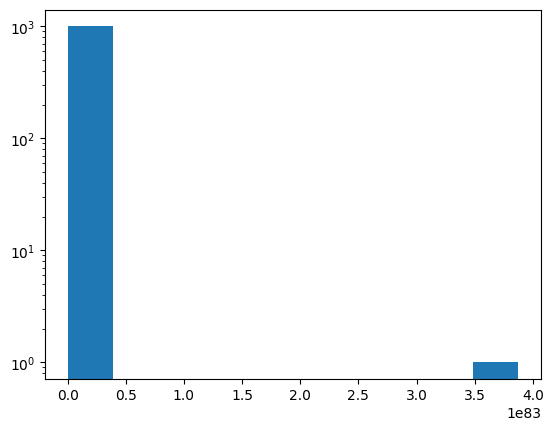

In [170]:
plt.hist(p0)
plt.yscale('log')

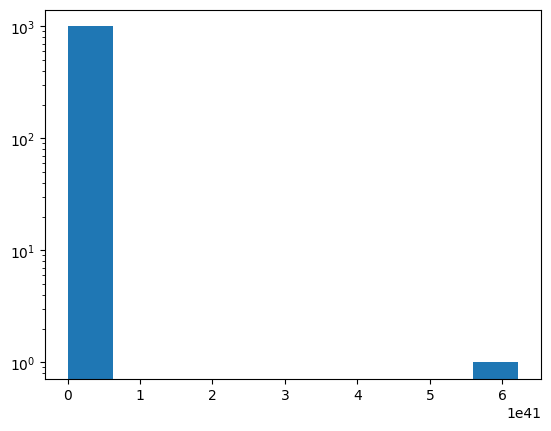

In [171]:
plt.hist(p1)
plt.yscale('log')

## Discussion

## Conclusion